# In this Python script, we will focus on comments on a YouTube video posted by Amazon to show you how to use the proposed approach. 

# First, download all the comments as well as metadata (number of likes, submission time) on a campaign. In this example, all the information is saved in an Excel file called Amazon_processed.xlsx 

# Second, use a machine learning algorithm (e.g., LDA) or human raters to assign a topic for each comment.

# Third, create an Excel (or CSV) file that has the following columns: comment ( each comment content), like (number of likes), Dominant_topic (the main topic of each comment; it's a number that stands for the main topic), and time_order (organize the comments from the oldest to the most recent, assign number 1 to the first comment, etc.).

# Last, when running this script, replace Amazon_processed.xlsx with your own file that has the necessary columns.

In [1]:
#generate the list of top comment topics and the most salient top comment topic for each commenter

import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

def generate_start_list(n):#from commenter 1 to 11, their faced top comments will be the first 10 comments
    start_list = []
    for i in range(n):
        start_list.append(i)
    return start_list
    
def topic_index_list(df,n):#generate index list for n top comments with the largest likes in the past (from largest to smallest) 
    topic_list=[]
    for i in range(n+1):
        topic_list.append(generate_start_list(n)) 
    #when two comments have the same number of likes, the most recent one is kept     
    for i in tqdm(range(n+1,len(df['like']))):
        #get the indexes for the n largest values(from largest to smalles) from df.like[:i]
        index_list=np.argsort(df.like[:i])[-n:].tolist()[::-1] 
        topic_list.append(index_list)
    return topic_list


def topic_list(df,n):#generate a comment list for n top comments with the largest likes in the past (from largest to smallest) 
    topic_type_list = [[df['Dominant_Topic'][i] for i in topic_index] for topic_index in topic_index_list(df,n)]
    return topic_type_list

def most_salient(lst): #generate topic_weight_dict in which key is each unique comment topic and value is sum of weighted index 
    topic_weight_dict={}
    values=np.array(lst[::-1])
    for item in set(lst):
        index_array=np.where(values == item)[0]
        index_array_new=np.asarray(index_array)+1 #assign weight of 10 to 1st top comment (with the largest likes),9 to the 2nd
        topic_weight_dict[item]=np.sum(index_array_new)#for each top comment type, sum all the weights
        
    return topic_weight_dict

def generate_most_salient_comment(df,n): #select the top comment topic with the largest summed weights
    top_comment_type=[]
    for item in tqdm(topic_list(df,n)):
        topic_weight_dict=most_salient(item)
        topic=max(topic_weight_dict, key=topic_weight_dict.get)
        top_comment_type.append(topic)
    return top_comment_type

def check_topic_with_same_weight(df,n):
    #generate a list of top comment topics with the same summed weights, ranging from the ones with largest to smallest weights
    topic_duplicate_weight=[]
    for item in tqdm(topic_list(df,n)):
        topic_weight_dict=most_salient(item)
        rev_multidict = {}
        for key, value in topic_weight_dict.items():
            rev_multidict.setdefault(value, set()).add(key)
        duplicate_lst=[values for key, values in rev_multidict.items() if len(values) > 1]
        topic_duplicate_weight.append(duplicate_lst)
    return topic_duplicate_weight

def refined_most_salient_comment(df,n):#select the top comment topic with the largest summed weights and least topic list index
    refined_most_salient=[]
    cat_list=zip(topic_list(df,n),generate_most_salient_comment(df,n),check_topic_with_same_weight(df,n))
    for item in tqdm(cat_list): #eacm item is a tuple of three elements:a topic list,salient topic,and a list of duplicate topics
        if len(item[2])>0:#if there are duplicate topics with the same weight
            if item[1] in item[2][0]: #if the most salient number is the same as any duplicate topic with large weight
                index_list=[]
                for topic in item[2][0]:
                    index_list.append(item[0].index(topic))
                salient_topic=item[0][min(index_list)]    
                refined_most_salient.append(salient_topic) 
            else:
                salient_topic=item[1] 
                refined_most_salient.append(salient_topic)
        else: 
            salient_topic=item[1] 
            refined_most_salient.append(salient_topic)
    return refined_most_salient

if __name__ == '__main__':
    df = pd.read_excel('Amazon_processed.xlsx',encoding='utf-8') 
    n = 10
    df['top_comment_index']=topic_index_list(df,n)
    df['top_comment_topic']=topic_list(df,n)
    df['most_salient_comment_topic']=generate_most_salient_comment(df,n)
    df['topic_with_duplicate_weight']=check_topic_with_same_weight(df,n)
    df['refined_most_salient_comment']=refined_most_salient_comment(df,n)
    df.to_excel('Amazon_processed.xlsx',encoding='utf-8') 
    print('==================Done==================')
    

100%|██████████| 122/122 [00:00<00:00, 7410.22it/s]
122it [00:00, 119250.78it/s]


==================Done==================


In [2]:
#for each top comment topic, generate the cumalative number of top comment topic falling into this topic over time
import pandas as pd
from tqdm import tqdm

def generate_cumulative_topic(df):
    cumulative_topic=[]
    score=0
    for item in tqdm(df['refined_most_salient_comment']):
        if item==n:
            score+=1
            cumulative_topic.append(score)
        else:
            cumulative_topic.append(score)

    return cumulative_topic

if __name__ == '__main__':
    df = pd.read_excel('Amazon_processed.xlsx',encoding='utf-8')
    for n in [0,1,2,3,4]:
        df['cumulative_topic_{}'.format(n)]=generate_cumulative_topic(df)
    df.to_excel('Amazon_processed.xlsx',encoding='utf-8')
    print('==================Done==================')

100%|██████████| 122/122 [00:00<00:00, 122446.78it/s]


==================Done==================


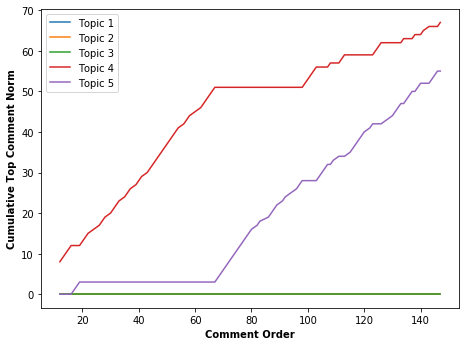

In [3]:
#Generate figure 1

import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_excel('Amazon_processed.xlsx',encoding='utf-8')
#does not consider the first 10 commenters who were not exposed to 10 top comments
df=df[df['time_order']>11]

#plt.rcParams["font.family"] = "Times New Roman"

# line 1 points
x1 = df['time_order']
y1 = df['cumulative_topic_0']
# plotting the line 1 points 
plt.plot(x1, y1, label = "Topic 1")

# line 2 points
x2 = df['time_order']
y2 = df['cumulative_topic_1']
# plotting the line 2 points 
plt.plot(x2, y2, label = "Topic 2")

# line 3 points
x2 = df['time_order']
y2 = df['cumulative_topic_2']
# plotting the line 2 points 
plt.plot(x2, y2, label = "Topic 3")

# line 4 points
x2 = df['time_order']
y2 = df['cumulative_topic_3']
# plotting the line 2 points 
plt.plot(x2, y2, label = "Topic 4")

# line 4 points
x2 = df['time_order']
y2 = df['cumulative_topic_4']
# plotting the line 2 points 
plt.plot(x2, y2, label = "Topic 5")


plt.xlabel('Comment Order',fontweight='bold')
# Set the y axis label of the current axis.
plt.ylabel('Cumulative Top Comment Norm',fontweight='bold')
# Set a title of the current axes.
#plt.title('Cumulative Top Comment Norm Falling into Each Topic Type Over Time',style='italic')
# show a legend on the plot
plt.legend()

#set the size of the figure
fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)


# Display a figure.
plt.show()